In [16]:
import numpy as np
import GPy
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [17]:
N = 50
noise_var = 0.05

X_train = np.linspace(-5,5,50)[:,None]
k = GPy.kern.RBF(1)
Y_train = np.random.multivariate_normal(np.zeros(N),k.K(X_train)+np.eye(N)*np.sqrt(noise_var)).reshape(-1,1)

X_test = np.linspace(-10,10,100)[:,None]
Y_test = X_test #bara bull

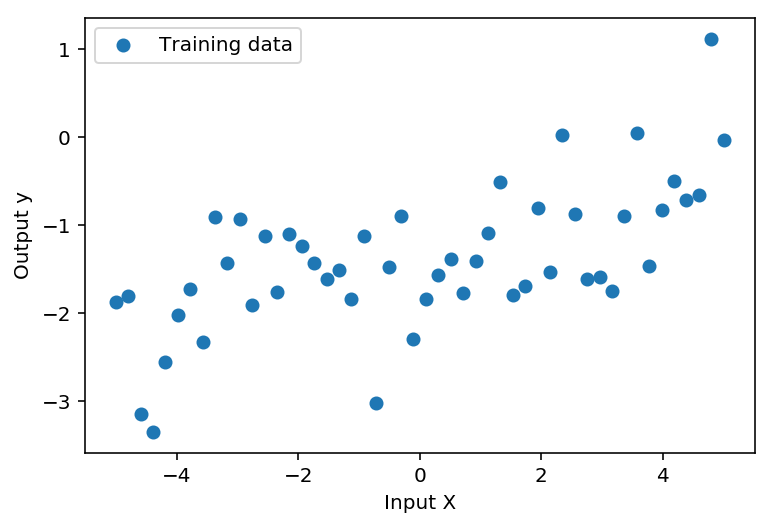

In [18]:
plt.scatter(X_train,Y_train, label='Training data')
plt.xlabel('Input X')
plt.ylabel('Output y')
plt.legend()

In [19]:
X_train_tensor = torch.from_numpy(X_train)
Y_train_tensor = torch.from_numpy(Y_train)
X_test_tensor  = torch.from_numpy(X_test)
Y_test_tensor  = torch.from_numpy(Y_test)

train_tensor_dataset = torch.utils.data.TensorDataset(X_train_tensor, Y_train_tensor)
test_tensor_dataset  = torch.utils.data.TensorDataset(X_test_tensor, Y_test_tensor)

data_loader_train = torch.utils.data.DataLoader(dataset=train_tensor_dataset, 
                                          batch_size=10, 
                                          shuffle=True,
                                          num_workers=4)

data_loader_test = torch.utils.data.DataLoader(dataset=test_tensor_dataset, 
                                          batch_size=100, 
                                          shuffle=False,
                                          num_workers=4)

In [64]:
# Neural Network Model
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = F.dropout(x, p=0.1, training=True)
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.1, training=True)
        x = self.fc2(x)
        return x

In [75]:
model = Model(input_size=1, hidden_size=10, output_size=1)

optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.001,
                            weight_decay=1.0778889384649698e-06,
                            momentum=0.9)

loss_criterion = torch.nn.MSELoss()

In [76]:
train_loss = []
test_loss  = []

# Train the Model
for epoch in range(40):
    #print(f'Epoch {epoch}/40')
    
    #train
    batchloss_train = []
    for X_train_batch, Y_train_batch in data_loader_train:  
        # Convert torch tensor to Variable
        X_train_tensor = Variable(X_train_batch).float()
        Y_train_tensor = Variable(Y_train_batch).float()
        # Forward + Backward + Optimize
        optimizer.zero_grad()  # zero the gradient buffer
        predicted_Y = model(X_train_tensor)
        trainloss = loss_criterion(predicted_Y, Y_train_tensor)
        trainloss.backward()
        optimizer.step()
        batchloss_train.append(trainloss.data[0])
        
    #scheduler.step()
    train_loss.append(np.mean(batchloss_train))
    
print('Train RMSE: {}'.format(np.sqrt(train_loss[-1])))

Train RMSE: 0.6802956819799173


In [77]:
#Test 
N_forward = 1000
Y_hat_matrix = np.zeros([N_forward, 100])
for i in range(N_forward):
    for X_test_batch, Y_test_batch in data_loader_test:
        Y_hat = model(Variable(X_test_batch).float())
    Y_hat_matrix[i,:] = Y_hat.data.numpy().T

In [78]:
y_hat_MC_mean = np.mean(Y_hat_matrix, axis=0)
y_hat_MC_std = np.std(Y_hat_matrix, axis=0)

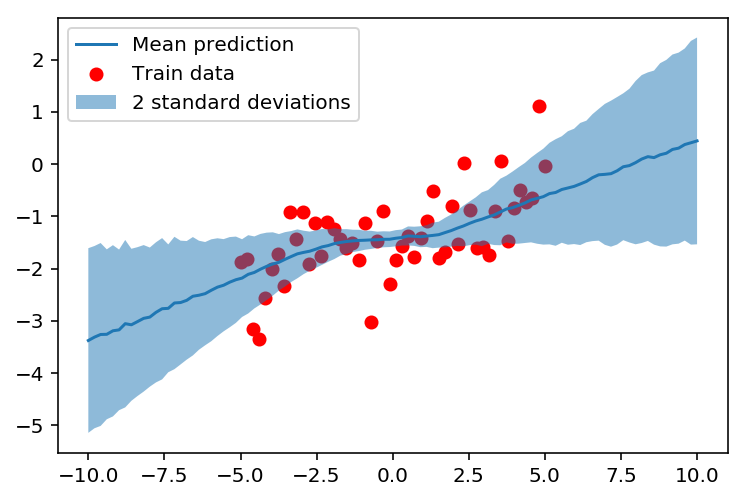

In [79]:
plt.scatter(X_train, Y_train, label='Train data', color='red')
plt.plot(X_test, y_hat_MC_mean, label='Mean prediction')
plt.fill_between(X_test.flatten(), 
                 y1=y_hat_MC_mean-2*y_hat_MC_std, 
                 y2=y_hat_MC_mean+2*y_hat_MC_std,
                 alpha=0.5,
                label='2 standard deviations')
plt.legend()

 /home/dsteinar/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


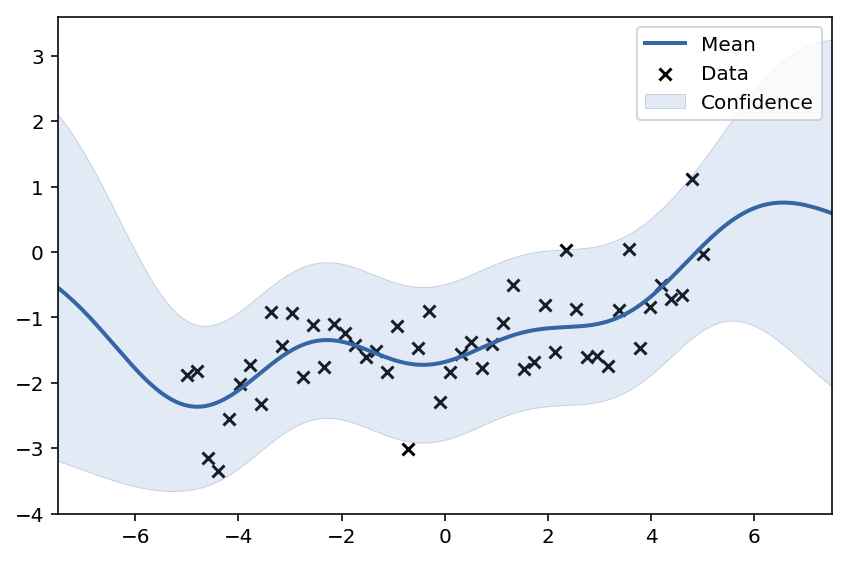

In [59]:
m_full = GPy.models.GPRegression(X_train,Y_train)
m_full.optimize('bfgs')
m_full.plot()